In [1]:
# default_exp experiments.nbeats.hyperopt_epf

In [2]:
# export
import time
import os
# Limit number of threads in numpy and others to avoid throttling
os.environ["OMP_NUM_THREADS"] = "2" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "2" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "3" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "2" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "3" # export NUMEXPR_NUM_THREADS=6

import numpy as np
import pandas as pd
import argparse
import pickle
import glob
import itertools
import random
from datetime import datetime
from functools import partial

from nixtla.data.scalers import Scaler
from nixtla.data.datasets.epf import EPF, EPFInfo
from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_fast import TimeSeriesLoader
from nixtla.losses.numpy import mae, mape, smape, rmse, pinball_loss

# Models
from nixtla.models.nbeats.nbeats import Nbeats

import warnings
warnings.filterwarnings("ignore")

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# DATA WRANGLING AND EVALUATION UTILS

In [3]:
# export

############################################################################################
#### COMMON
############################################################################################

def forecast_evaluation_table(y, y_hat):
    y = y.reshape(-1)
    y_hat = y_hat.reshape(-1)
    y_mask = (1-np.isnan(y)) * 1
    print("np.sum(y_mask)", np.sum(y_mask))

    _mae   = np.round(mae(y=y, y_hat=y_hat),5)
    _mape  = np.round(mape(y=y, y_hat=y_hat),5)
    _smape = np.round(smape(y=y, y_hat=y_hat),5)
    _rmse  = np.round(rmse(y=y, y_hat=y_hat),5)

    performance = pd.DataFrame({'metric': ['mae', 'mape', 'smape', 'rmse'],
                                'measure': [_mae, _mape, _smape, _rmse]})                          

    return performance

def protect_nan_reported_loss(model):
    # TODO: Pytorch numerical error hacky protection, protect from losses.numpy.py
    reported_loss = model.final_outsample_loss
    if np.isnan(model.final_insample_loss):
        reported_loss = 100
    if model.final_insample_loss<=0:
        reported_loss = 100

    if np.isnan(model.final_outsample_loss):
        reported_loss = 100    
    if model.final_outsample_loss<=0:
        reported_loss = 100    
    return reported_loss


def get_last_n_timestamps_mask_df(Y_df, n_timestamps):
    # Creates outsample_mask
    # train_mask: 1 last_n_timestamps, 0 timestamps until last_n_timestamps

    last_df = Y_df.copy()[['unique_id', 'ds']]
    last_df.sort_values(by=['unique_id', 'ds'], inplace=True, ascending=False)
    last_df.reset_index(drop=True, inplace=True)

    last_df = last_df.groupby('unique_id').head(n_timestamps)
    last_df['mask'] = 1

    last_df = last_df[['unique_id', 'ds', 'mask']]

    mask_df = Y_df.merge(last_df, on=['unique_id', 'ds'], how='left')
    mask_df['mask'] = mask_df['mask'].fillna(0)    # The first len(Y)-n_hours used as train

    mask_df = mask_df[['unique_id', 'ds', 'mask']]
    mask_df.sort_values(by=['unique_id', 'ds'], inplace=True)

    assert len(mask_df)==len(Y_df), \
        f'The mask_df length {len(mask_df)} is not equal to Y_df length {len(Y_df)}'

    return mask_df

def balance_data(Y_df, Xt_df):
    # Create balanced placeholder dataframe
    balance_ids = {'unique_id': Y_df.unique_id.unique(),
                   'ds': Y_df.ds.unique()}

    product_list = list(itertools.product(*list(balance_ids.values())))
    balance_df = pd.DataFrame(product_list, columns=list(balance_ids.keys()))

    # Create mask for weighted losses for the las 2 years of each unique_id
    weights_df = get_last_n_timestamps_mask_df(Y_df=Y_df, n_timestamps=365*2*24)
    weights_df['weights'] = weights_df['mask']
    del weights_df['mask']
    
    # Balance with merge
    Y_balanced_df = balance_df.merge(Y_df, on=['unique_id', 'ds'], how='left')
    Xt_balanced_df = balance_df.merge(Xt_df, on=['unique_id', 'ds'], how='left')
    weights_balanced_df = balance_df.merge(weights_df, on=['unique_id', 'ds'], how='left')
    #print(weights_balanced_df.groupby(['unique_id', 'weights']).agg({'ds': ['min', 'max']}))

    print('\n')
    print('Y_df.shape \t', Y_df.shape)
    print('Xt_df.shape \t', Xt_df.shape)
    print('Y_balanced_df.shape \t', Y_balanced_df.shape)
    print('Xt_balanced_df.shape \t', Xt_balanced_df.shape)
    print('weights_balanced_df.shape \t', weights_balanced_df.shape)

    return Y_balanced_df, Xt_balanced_df, weights_balanced_df

def scale_data(Y_df, X_df, mask, normalizer_y, normalizer_x):
    y_shift = None
    y_scale = None

    mask = mask.astype(int)
    
    if normalizer_y is not None:
        scaler_y = Scaler(normalizer=normalizer_y)
        Y_df['y'] = scaler_y.scale(x=Y_df['y'].values, mask=mask)
    else:
        scaler_y = None
    # Exogenous are always scaled to help learning
    if normalizer_x is not None:
        scaler_x = Scaler(normalizer=normalizer_x)
        X_df['Exogenous1'] = scaler_x.scale(x=X_df['Exogenous1'].values, mask=mask)

        scaler_x = Scaler(normalizer=normalizer_x)
        X_df['Exogenous2'] = scaler_x.scale(x=X_df['Exogenous2'].values, mask=mask)

    filter_variables = ['unique_id', 'ds', 'Exogenous1', 'Exogenous2', 'week_day'] + \
                       [col for col in X_df if (col.startswith('day'))]
                       #[col for col in X_df if (col.startswith('_hour_'))]
    X_df = X_df[filter_variables]

    return Y_df, X_df, scaler_y



############################################################################################
#### KIN
############################################################################################    

def prepare_data_Kin(mc, Y_df, Xt_df, S_df):

    #-------------------------------------------- Data Wrangling --------------------------------------------#
    Y_balanced_df, Xt_balanced_df, weights_balanced_df = balance_data(Y_df, Xt_df)
    del Y_df, Xt_df
    
    #------------------------------------- Available and Validation Mask ------------------------------------#
    # Create available_mask and sample_mask
    mask_df = Y_balanced_df[['unique_id', 'ds', 'y']].copy()
    mask_df['available_maskY'] = (1-Y_balanced_df.y.isnull().values)
    mask_df['available_maskX'] = (1-Xt_balanced_df['Exogenous1'].isnull().values)
    mask_df['available_mask'] = mask_df['available_maskY'] * mask_df['available_maskX']

    del mask_df['y']
    del mask_df['available_maskX']
    del mask_df['available_maskY']

    # Train Validation splits
    #                        ds                    
    #                       min                 max
    # unique_id mask                               
    # BE        0.0  2013-01-04 2015-01-03 23:00:00
    #           1.0  2011-01-09 2013-01-03 23:00:00
    # FR        0.0  2013-01-04 2015-01-03 23:00:00
    #           1.0  2011-01-09 2013-01-03 23:00:00
    # NP        0.0  2014-12-28 2016-12-26 23:00:00
    #           1.0  2013-01-01 2014-12-27 23:00:00
    # PJM       0.0  2014-12-28 2016-12-26 23:00:00
    #           1.0  2013-01-01 2014-12-27 23:00:00
    mask_df['sample_mask1'] = (mask_df['ds'] <= pd.to_datetime('2013-01-03 23:00:00')) * 1
    mask_df['sample_mask2'] = (mask_df['ds'] <= pd.to_datetime('2014-12-27 23:00:00')) * 1
    mask_df['sample_mask'] = mask_df['sample_mask2']

    #-------------------------------------------- Data Wrangling --------------------------------------------#

    # Scale data # TODO: write sample_mask conditional/groupby(['unique_id]) scaling
    # Xt_scaled_df = scale_data(Xt_df=Xt_balanced_df, mask_df=mask_df)
    train_mask = mask_df.available_mask.values * mask_df.available_mask.values
    Y_scaled_df, Xt_scaled_df, scaler_y = scale_data(Y_df=Y_balanced_df, X_df=Xt_balanced_df, mask=train_mask, 
                                      normalizer_y=mc['normalizer_y'], normalizer_x=mc['normalizer_x'])
    del Y_balanced_df
    del Xt_balanced_df

    ts_dataset = TimeSeriesDataset(Y_df=Y_scaled_df, X_df=Xt_scaled_df, S_df=S_df, mask_df=mask_df)

    #-------------------------------------------- Declare Loaders -------------------------------------------#

    train_ts_loader = TimeSeriesLoader(ts_dataset=ts_dataset,
                                       model='nbeats',
                                       offset=0, #offset,
                                       window_sampling_limit=ts_dataset.max_len, 
                                       input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                       output_size=int(mc['output_size']),
                                       idx_to_sample_freq=int(mc['idx_to_sample_freq']),
                                       batch_size=int(mc['batch_size']),
                                       is_train_loader=True,
                                       shuffle=True, random_seed=int(mc['random_seed']))

    print("train_ts_loader.ts_windows.shape", train_ts_loader.ts_windows.shape)
    print(f"len(train_loader.windows_sampling_idx) * 24 = \
       \t {len(train_ts_loader.windows_sampling_idx)} * 24 = {len(train_ts_loader.windows_sampling_idx) * 24}")
    print("\n")

    val_ts_loader = TimeSeriesLoader(ts_dataset=ts_dataset,
                                     model='nbeats',
                                     offset=0, #offset,
                                     window_sampling_limit=ts_dataset.max_len,
                                     input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                     output_size=int(mc['output_size']),
                                     idx_to_sample_freq=int(mc['idx_to_sample_freq']),
                                     batch_size=1024,
                                     is_train_loader=False, # Samples the opposite of train_outsample_mask
                                     shuffle=False, random_seed=int(mc['random_seed']))

    print("val_ts_loader.ts_windows.shape", val_ts_loader.ts_windows.shape)
    print(f"len(val_loader.windows_sampling_idx) * 24 = \
       \t {len(val_ts_loader.windows_sampling_idx)} * 24 = {len(val_ts_loader.windows_sampling_idx) * 24}")
    print("\n")

    mc['t_cols'] = ts_dataset.t_cols
    return mc, train_ts_loader, val_ts_loader, scaler_y




############################################################################################
#### CRISTIAN
############################################################################################

def train_val_split(len_series, offset, window_sampling_limit, n_val_weeks, ds_per_day):
    last_ds = len_series - offset
    first_ds = max(last_ds - window_sampling_limit, 0)

    last_day = int(last_ds/ds_per_day)
    first_day = int(first_ds/ds_per_day)

    days = set(range(first_day, last_day)) # All days, to later get train days
    # Sample weeks from here, -7 to avoid sampling from last week
    # To not sample first week and have inputs
    sampling_days = set(range(first_day + 7, last_day - 7))
    validation_days = set({}) # Val days set
    
    # For loop for n of weeks in validation
    for i in range(n_val_weeks):
        # Sample random day, init of week
        init_day = random.sample(sampling_days, 1)[0]
        # Select days of sampled init of week
        sampled_days = list(range(init_day, min(init_day+7, last_day)))
        # Add days to validation days
        validation_days.update(sampled_days)
        # Remove days from sampling_days, including overlapping resulting previous week
        days_to_remove = set(range(init_day-6, min(init_day+7, last_day)))
        sampling_days = sampling_days.difference(days_to_remove)

    train_days = days.difference(validation_days)

    train_days = sorted(list(train_days))
    validation_days = sorted(list(validation_days))

    train_idx = []
    for day in train_days:
        hours_idx = range(day*ds_per_day,(day+1)*ds_per_day)
        train_idx += hours_idx

    val_idx = []
    for day in validation_days:
        hours_idx = range(day*ds_per_day,(day+1)*ds_per_day)
        val_idx += hours_idx

    assert all([idx < last_ds for idx in val_idx]), 'Leakage!!!!'
    
    return train_idx, val_idx

def prepare_data_cristian(mc, Y_df, X_df, S_df):

    #window_sampling_limit = int(mc['window_sampling_limit_multiplier']) * int(mc['output_size'])
    window_samplint_limit = ts_dataset.max_len
    n_val_weeks = int(mc['n_val_weeks'])
    output_size = mc['output_size']
        
    #--------------------------------------- Train and Validation Mask --------------------------------------#
    
    # train_mask: 1 to keep, 0 to hide
    train_outsample_mask = np.ones(len(Y_df), dtype=int)
    if random_validation:
        print('Random validation activated')
        np.random.seed(1)
        random.seed(1)
        _, val_idx = train_val_split(len_series=len(Y_df), offset=0,
                                window_sampling_limit=window_sampling_limit,
                                n_val_weeks=n_val_weeks, ds_per_day=24)
        train_outsample_mask[val_idx] = 0
    else:
        print('Random validation de-activated')
        train_outsample_mask[-(n_val_weeks * 7 * output_size):] = 0

    print(f'Train {sum(train_outsample_mask)} hours = {np.round(sum(train_outsample_mask)/(24*365),2)} years')
    print(f'Validation {sum(1-train_outsample_mask)} hours = {np.round(sum(1-train_outsample_mask)/(24*365),2)} years')

    y_validation_vector = Y_df['y'].values[(1-train_outsample_mask)==1] # To compute validation loss in true scale

    #-------------------------------------------- Data Wrangling --------------------------------------------#
    
    # Transform data with scale transformation (Y_df, X_df, offset, normalizer_x, normalizer_y
    # Avoid change original data
    Y_scaled_df = Y_df.copy()
    X_scaled_df = X_df.copy()    
    Y_scaled_df, X_scaled_df, scaler_y = transform_data(Y_df=Y_scaled_df,
                                                        X_df=X_scaled_df,
                                                        mask=train_outsample_mask,
                                                        normalizer_y = mc['normalizer_y'],
                                                        normalizer_x = mc['normalizer_x'])

    #-------------------------------------------- Declare Loaders -------------------------------------------#

    ts_dataset = TimeSeriesDataset(Y_df=Y_df_scaled, X_df=X_df_scaled, ts_train_mask=train_outsample_mask)

    train_ts_loader = TimeSeriesLoader(model='nbeats',
                                       ts_dataset=ts_dataset,
                                       window_sampling_limit=window_sampling_limit,
                                       offset=0,
                                       input_size=int(mc['input_size_multiplier'] * mc['output_size']),
                                       output_size=int(mc['output_size']),
                                       idx_to_sample_freq=int(mc['idx_to_sample_freq']),
                                       batch_size=int(mc['batch_size']),
                                       is_train_loader=True,
                                       shuffle=True)

    val_ts_loader = TimeSeriesLoader(model='nbeats',
                                     ts_dataset=ts_dataset,
                                     window_sampling_limit=window_sampling_limit,
                                     offset=0,
                                     input_size=int(mc['input_size_multiplier'] * mc['output_size']),
                                     output_size=int(mc['output_size']),
                                     idx_to_sample_freq=24, #TODO: pensar esto
                                     batch_size=int(mc['batch_size']),
                                     is_train_loader=False,
                                     shuffle=False)

    mc['t_cols'] = ts_dataset.t_cols
    return mc, train_ts_loader, val_ts_loader, scaler_y


# RUN VALIDATION CODE

In [4]:
# export
# run_val_nbeatsx(hyperparameters, Y_df, X_df, data_augmentation, random_validation, trials, trials_file_name)


def run_val_nbeatsx(mc, Y_df, Xt_df, S_df, trials, trials_file_name, final_evaluation=False, return_model=False):

    # Save trials, can analyze progress
    if trials is not None:
        save_every_n_step = 5
        current_step = len(trials.trials)
        if (current_step % save_every_n_step==0):
            with open(trials_file_name, "wb") as f:
                pickle.dump(trials, f)

    start_time = time.time()    
    
    #---------------------------------------- Parse  Hyperparameters ----------------------------------------#
    # CONSIDERO ESTO INNECESARIO
    # if data_augmentation:
    #     mc['idx_to_sample_freq'] = 1
    # else:
    #     mc['idx_to_sample_freq'] = 24

    # mc['input_size_multiplier'] = 7
    # mc['output_size'] = 24
    # mc['window_sampling_limit_multiplier'] = 365*4 # para matchear weron
    # mc['shared_weights'] = False
    # mc['n_harmonics'] = 1 # no afecta
    # mc['n_polynomials'] = 4 # no afecta
    # mc['x_s_n_hidden'] = 0 # no afecta
    # mc['weight_decay'] = 0
    # mc['lr_decay'] = 0.5 #TODO: DIFERENTE A WERON
    # mc['n_lr_decay_steps'] = 3 #TODO: DIFERENTE A WERON
    # mc['n_iterations'] = 30000 # para matchear weron 1,000*(365*4)/256 
    # mc['early_stopping'] = 10 # TODO: save model para matchear weron con 20
    # mc['eval_steps'] = 100 # para matchear weron (365*24*3)/256
    # mc['train_every_n_steps'] = 1
    # mc['frequency'] = 'H' # no afecta
    # mc['seasonality'] = 24 # no afecta
    # mc['loss_hypar'] = None
    # mc['val_loss'] = mc['loss']

    # mc['n_hidden'] = len(mc['stack_types']) * [ [int(mc['n_hidden_1']), int(mc['n_hidden_2'])] ]

    # include_var_dict = {'y': [],
    #                     'Exogenous1': [],
    #                     'Exogenous2': [],
    #                     'week_day': []}

    # if mc['incl_pr1']: include_var_dict['y'].append(-2)
    # if mc['incl_pr2']: include_var_dict['y'].append(-3)
    # if mc['incl_pr3']: include_var_dict['y'].append(-4)
    # if mc['incl_pr7']: include_var_dict['y'].append(-8)
        
    # if mc['incl_ex1_0']: include_var_dict['Exogenous1'].append(-1)
    # if mc['incl_ex1_1']: include_var_dict['Exogenous1'].append(-2)
    # if mc['incl_ex1_7']: include_var_dict['Exogenous1'].append(-8)
        
    # if mc['incl_ex2_0']: include_var_dict['Exogenous2'].append(-1)
    # if mc['incl_ex2_1']: include_var_dict['Exogenous2'].append(-2)
    # if mc['incl_ex2_7']: include_var_dict['Exogenous2'].append(-8)

    # if mc['incl_day']: include_var_dict['week_day'].append(-1)
    # mc['include_var_dict'] = include_var_dict

    mc['include_var_dict'] = {'y': [-2, -3, -8],
                              'Exogenous1': [-1, -2, -8],
                              'Exogenous2': [-1, -2, -8],
                              'week_day': [-1]}

    n_hidden = int(mc['n_hidden'])
    mc['n_hidden_list'] =  2*[[n_hidden, n_hidden]]
    # print(75*'=')
    # print(pd.Series(mc))
    # print(75*'=' + '\n')

    #------------------------------------------------- Data -------------------------------------------------#
    
    #mc, train_ts_loader, val_ts_loader, scaler_y = prepare_data_Cristian(mc=mc, Y_df=Y_df, X_df=Xt_df, S_df=None)
    mc, train_ts_loader, val_ts_loader, scaler_y = prepare_data_Kin(mc=mc, Y_df=Y_df, Xt_df=Xt_df, S_df=S_df)
    
    #---------------------------------- Instantiate model, fit and predict ----------------------------------#

    # Instantiate and train model
    model = Nbeats(input_size_multiplier=mc['input_size_multiplier'],
                   output_size=int(mc['output_size']),
                   shared_weights=mc['shared_weights'],
                   initialization=mc['initialization'],
                   activation=mc['activation'],
                   stack_types=mc['stack_types'],
                   n_blocks=mc['n_blocks'],
                   n_layers=mc['n_layers'],
                   #n_hidden=2*[2*[int(mc['n_hidden'])]], # TODO; Revisar n_hidden1, n_hidden2 <------
                   n_hidden=mc['n_hidden_list'],
                   #n_hidden=2*[[256,256]],
                   n_harmonics=int(mc['n_harmonics']),
                   n_polynomials=int(mc['n_polynomials']),
                   x_s_n_hidden = int(mc['x_s_n_hidden']),
                   exogenous_n_channels=int(mc['exogenous_n_channels']),
                   include_var_dict=mc['include_var_dict'],
                   t_cols=mc['t_cols'],
                   batch_normalization = mc['batch_normalization'],
                   dropout_prob_theta=mc['dropout_prob_theta'],
                   dropout_prob_exogenous=mc['dropout_prob_exogenous'],
                   learning_rate=float(mc['learning_rate']),
                   lr_decay=float(mc['lr_decay']),
                   n_lr_decay_steps=float(mc['n_lr_decay_steps']),
                   weight_decay=mc['weight_decay'],
                   l1_theta=mc['l1_theta'],
                   n_iterations=int(mc['n_iterations']),
                   early_stopping=int(mc['early_stopping']),
                   loss=mc['loss'],
                   loss_hypar=float(mc['loss_hypar']),
                   val_loss=mc['val_loss'],
                   frequency=mc['frequency'],
                   seasonality=int(mc['seasonality']),
                   random_seed=int(mc['random_seed']))

    # Fit model
    model.fit(train_ts_loader=train_ts_loader, val_ts_loader=val_ts_loader, eval_steps=mc['eval_steps'])
    
    reported_loss = protect_nan_reported_loss(model)
    run_time = time.time() - start_time

    # # Scale to original scale
    # TODO: reescalar o no reescalar a la y?
    # TODO: el modelo tendría que reescalar al interior, esto es medio feo
    # if mc['normalizer_y'] is not None:
    #     y_true, y_hat, _ = model.predict(ts_loader=val_loader, eval_mode=True)
    #     y_true = scaler_y.inv_scale(x=y_true)
    #     y_hat = scaler_y.inv_scale(x=y_hat)
    #     val_mae = mae(y=y_true, y_hat=y_hat)
    #     reported_loss = val_mae

    results =  {'loss': reported_loss,
                'loss_name': mc['val_loss'],
                'mc': mc,
                'final_insample_loss': model.final_insample_loss,
                'final_outsample_loss': model.final_outsample_loss,
                'trajectories': model.trajectories,
                'run_time': run_time,
                'status': STATUS_OK}
    
    if final_evaluation:
        print('Best Model Evaluation')
        y_true, y_hat, _ = model.predict(ts_loader=val_ts_loader, eval_mode=True)
        print(forecast_evaluation_table(y_true, y_hat))
        print('\n')

        print('Best Model Hyperpars')
        print(75*'=')
        print(pd.Series(mc))
        print(75*'='+'\n')
    
    if return_model:
        return model, train_ts_loader, val_ts_loader
    
    return results
    

# EXPERIMENT SPACES

In [5]:
#export
# TODO: eliminate n_harmonics, n_polynomials think on kwargs maybe?
# TODO: think on n_consistency for exogenous_n_channels -> n_xt_channels
# TODO: x_s_n_hidden -> n_xs_hidden
# TODO: input_size_multiplier -> Change for n_xt?
# TODO: n_hidden -> n_theta_list
def get_experiment_space(args):
    if args.space=='nbeats_cristian':
        space = {# Architecture parameters
                 'input_size_multiplier': hp.choice('input_size_multiplier', [7]),
                 'output_size': hp.choice('output_size', [24]),
                 'shared_weights': hp.choice('shared_weights', [False]),
                 'activation': hp.choice('activation', ['relu','softplus','tanh','selu','lrelu','prelu','sigmoid']),
                 'initialization':  hp.choice('initialization', ['orthogonal','he_uniform','he_normal',
                                                                 'glorot_uniform','glorot_normal','lecun_normal']),
                 'stack_types': hp.choice('stack_types', [ ['identity'],
                                                            1*['identity']+['exogenous_wavenet'],
                                                                ['exogenous_wavenet']+1*['identity'],
                                                            1*['identity']+['exogenous_tcn'],
                                                                ['exogenous_tcn']+1*['identity'] ]),
                 'n_blocks': hp.choice('n_blocks', [ [1, 1] ]),
                 'n_layers': hp.choice('n_layers', [ [2, 2] ]),
                 'n_hidden': hp.quniform('n_hidden', 50, 500, 1),
                 'n_harmonics': hp.choice('n_harmonics', [1]),
                 'n_polynomials': hp.choice('n_polynomials', [2]),
                 'exogenous_n_channels': hp.quniform('exogenous_n_channels', 1, 10, 1),
                 'x_s_n_hidden': hp.choice('x_s_n_hidden', [0]),
                 # Regularization and optimization parameters
                 'batch_normalization': hp.choice('batch_normalization', [True, False]),
                 'dropout_prob_theta': hp.uniform('dropout_prob_theta', 0, 1),
                 'dropout_prob_exogenous': hp.uniform('dropout_prob_exogenous', 0, 0.5),
                 'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.1)),
                 'lr_decay': hp.choice('lr_decay', [0.5]),
                 'n_lr_decay_steps': hp.choice('n_lr_decay_steps', [3]),
                 'weight_decay': hp.loguniform('weight_decay', np.log(5e-4), np.log(0.01)),
                 'n_iterations': hp.choice('n_iterations', [args.max_epochs]),
                 'early_stopping': hp.choice('early_stopping', [40]),
                 'eval_steps': hp.choice('eval_steps', [100]),
                 'loss': hp.choice('loss', ['MAE']),
                 'loss_hypar': hp.choice('loss', [None]),
                 'val_loss': hp.choice('val_loss', [args.val_loss]),
                 'l1_theta': hp.choice('l1_theta', [0, hp.loguniform('lambdal1', np.log(1e-5), np.log(1))]),
                 # Data parameters
                 'normalizer_y': hp.choice('normalizer_y', [None, 'norm', 'norm1', 
                                                            'std', 'median', 'invariant']), # NUEVO <---------
                 'normalizer_x': hp.choice('normalizer_x', [None, 'norm', 'norm1',
                                                            'std', 'median', 'invariant']), # NUEVO <---------
                 'frequency': hp.choice('frequency', ['H']),
                 'seasonality': hp.choice('seasonality', [24]),
                 'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [24]), # NUEVO args <----------
                 'batch_size': hp.choice('batch_size', [128, 256, 512]), # NUEVO <---------
                 'random_seed': hp.quniform('random_seed', 1, 1000, 1)}
                 # CONSIDERO ESTO INNECESARIO
                 # 'n_hidden_1': hp.quniform('n_hidden_1', 50, 500, 1),
                 # 'n_hidden_2': hp.quniform('n_hidden_2', 50, 500, 1),
                 # 'include_var_dict': hp.choice('include_var_dict', [{'y': [-2, -3, -8],
                 #                                                     'Exogenous1': [-1, -2, -8],
                 #                                                     'Exogenous2': [-1, -2, -8],
                 #                                                     'week_day': [-1]}]),                 
                 # 'incl_pr1': hp.choice('incl_pr1', [True]),
                 # 'incl_pr2': hp.choice('incl_pr2', [True, False]),
                 # 'incl_pr3': hp.choice('incl_pr3', [True, False]),
                 # 'incl_pr7': hp.choice('incl_pr7', [True, False]),
                 # 'incl_ex1_0': hp.choice('incl_ex1_0', [True, False]),
                 # 'incl_ex1_1': hp.choice('incl_ex1_1', [True, False]),
                 # 'incl_ex1_7': hp.choice('incl_ex1_7', [True, False]),
                 # 'incl_ex2_0': hp.choice('incl_ex2_0', [True, False]),
                 # 'incl_ex2_1': hp.choice('incl_ex2_1', [True, False]),
                 # 'incl_ex2_7': hp.choice('incl_ex2_7', [True, False]),
                 # 'incl_day': hp.choice('incl_day', [True, False]),
                 # 'args.data_augmentation'
                 # 'n_val_weeks': hp.choice('n_val_weeks', [args.n_val_weeks]}

    elif args.space=='nbeats_collapsed':
        space= {# Architecture parameters
                'input_size_multiplier': hp.choice('input_size_multiplier', [7]),
                'output_size': hp.choice('output_size', [24]),
                'shared_weights': hp.choice('shared_weights', [False]),
                'activation': hp.choice('activation', ['relu','softplus','tanh','selu','lrelu','prelu','sigmoid']),
                'initialization':  hp.choice('initialization', ['orthogonal','he_uniform','he_normal',
                                                                'glorot_uniform','glorot_normal','lecun_normal']),
                'stack_types': hp.choice('stack_types', [['exogenous_wavenet']+1*['identity'],
                                                         ['exogenous_tcn']+1*['identity'] ]),
                'n_blocks': hp.choice('n_blocks', [ [1, 1] ]),
                'n_layers': hp.choice('n_layers', [ [2, 2] ]),
                'n_hidden': hp.quniform('n_hidden', 50, 500, 1),
                'n_harmonics': hp.choice('n_harmonics', [1]),
                'n_polynomials': hp.choice('n_polynomials', [2]),
                'exogenous_n_channels': hp.quniform('exogenous_n_channels', 1, 10, 1),
                'x_s_n_hidden': hp.choice('x_s_n_hidden', [0]),
                # Regularization and optimization parameters
                'batch_normalization': hp.choice('batch_normalization', [False]),
                'dropout_prob_theta': hp.uniform('dropout_prob_theta', 0, 1),
                'dropout_prob_exogenous': hp.uniform('dropout_prob_exogenous', 0, 0.5),
                'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.1)),
                'lr_decay': hp.uniform('lr_decay', 0.3, 1.0),
                'n_lr_decay_steps': hp.choice('n_lr_decay_steps', [3]),
                'weight_decay': hp.loguniform('weight_decay', np.log(5e-5), np.log(5e-3)),
                'n_iterations': hp.choice('n_iterations', [args.max_epochs]),
                'early_stopping': hp.choice('early_stopping', [40]),
                'eval_steps': hp.choice('eval_steps', [10]),
                'loss': hp.choice('loss', ['PINBALL']),
                'loss_hypar': hp.uniform('loss_hypar', 0.48, 0.51),
                'val_loss': hp.choice('val_loss', [args.val_loss]),
                'l1_theta': hp.choice('l1_theta', [0, hp.loguniform('lambdal1', np.log(1e-5), np.log(1))]),
                # Data parameters
                'normalizer_y': hp.choice('normalizer_y', [None]),
                'normalizer_x': hp.choice('normalizer_x', ['median']),
                'frequency': hp.choice('frequency', ['H']),
                'seasonality': hp.choice('seasonality', [24]),
                'include_var_dict': hp.choice('include_var_dict', [{'y': [-2, -3, -8],
                                                                    'Exogenous1': [-1, -2, -8],
                                                                    'Exogenous2': [-1, -2, -8],
                                                                    'week_day': [-1]}]),
                'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [24]),
                'batch_size': hp.choice('batch_size', [256]),
                'random_seed': hp.quniform('random_seed', 10, 20, 1)}
    
    else:
        print(f'Experiment space {args.space} not available')

    return space

def parse_trials(trials):
    # Initialize
    trials_dict = {'tid': [], 'loss': [], 'trajectories': [], 'mc': []}
    for tidx in range(len(trials)):
        # Main
        trials_dict['tid']  += [trials.trials[tidx]['tid']]
        trials_dict['loss'] += [trials.trials[tidx]['result']['loss']]
        trials_dict['trajectories'] += [trials.trials[tidx]['result']['trajectories']]

        # Model Configs
        mc = trials.trials[tidx]['result']['mc']
        trials_dict['mc'] += [mc]
    
    trials_df = pd.DataFrame(trials_dict)
    return trials_df

def main(args):
    #---------------------------------------------- Directories ----------------------------------------------#
    
    dataset = eval(args.dataset)
    dataset_str = dataset[0]
    for market in dataset[1:]:
        dataset_str += f'{market}_'
    output_dir = f'./results/{dataset_str}/{args.space}/'
    os.makedirs(output_dir, exist_ok = True)
    assert os.path.exists(output_dir), f'Output dir {output_dir} does not exist'

    hyperopt_file = output_dir + f'hyperopt_{args.experiment_id}.p'
    result_test_file = output_dir + f'result_test_{args.experiment_id}.p'

    #---------------------------------------------- Read  Data ----------------------------------------------#
    print('\n'+75*'-')
    print(28*'-', 'Preparing Dataset', 28*'-')
    print(75*'-'+'\n')

    #TEST_DATE = {'NP': '2016-12-27',
    #             'PJM':'2016-12-27',
    #             'BE':'2015-01-04',
    #             'FR': '2015-01-04',
    #             'DE':'2016-01-04'}
    #test_date = TEST_DATE[args.dataset]
    #Y_insample_df, Xt_insample_df, Y_outsample_df, Xt_outsample_df, _ = load_epf(directory='../data/',
    #                                                                             market=args.dataset,
    #                                                                             first_date_test=test_date,
    #                                                                             days_in_test=728)
    Y_df, Xt_df, S_df = EPF.load_groups(directory='data', groups=dataset)

    #-------------------------------------- Hyperparameter Optimization --------------------------------------#

    if not os.path.isfile(hyperopt_file):
        print('\n'+75*'-')
        print(22*'-', 'Start Hyperparameter  tunning', 22*'-')
        print(75*'-'+'\n')

        space = get_experiment_space(args)

        trials = Trials()
        fmin_objective = partial(run_val_nbeatsx, Y_df=Y_df, Xt_df=Xt_df, S_df=S_df,
                                 trials=trials, trials_file_name=hyperopt_file)
        fmin(fmin_objective, space=space, algo=tpe.suggest, max_evals=args.hyperopt_iters, trials=trials, verbose=True)

        # Save output
        with open(hyperopt_file, "wb") as f:
            pickle.dump(trials, f)

    print('\n'+75*'-')
    print(20*'-', 'Hyperparameter  tunning  finished', 20*'-')
    print(75*'-'+'\n')

    #----------------------------------------- Selected 'Best' Model -----------------------------------------#

    # Read and parse trials pickle
    trials = pickle.load(open(hyperopt_file, 'rb'))
    trials_df = parse_trials(trials)

    # Get best mc
    idx = trials_df.loss.idxmin()
    best_mc = trials_df.loc[idx]['mc']
    
    run_val_nbeatsx(best_mc, Y_df=Y_df, Xt_df=Xt_df, S_df=S_df,
                    trials=trials, trials_file_name=hyperopt_file, final_evaluation=True)

def parse_args():
    desc = "NBEATSx overfit"
    parser = argparse.ArgumentParser(description=desc)

    parser.add_argument('--dataset', type=str, required=True, help='NP')
    parser.add_argument('--space', type=str, required=True, help='Experiment hyperparameter space')
    parser.add_argument('--hyperopt_iters', type=int, help='hyperopt_iters')
    parser.add_argument('--max_epochs', type=int, required=False, default=2000, help='max train epochs')
    parser.add_argument('--val_loss', type=str, required=False, default=None, help='validation loss')
    parser.add_argument('--experiment_id', default=None, required=False, type=str, help='string to identify experiment')
    return parser.parse_args()


In [ ]:
# export
if __name__ == '__main__':

    # parse arguments
    args = parse_args()
    if args is None:
        exit()
    
    main(args)

# CUDA_VISIBLE_DEVICES=2 PYTHONPATH=. python nixtla/experiments/nbeats/hyperopt_epf.py --dataset 'NP' --space "nbeats_collapsed" --hyperopt_iters 200 --val_loss "SMAPE" --experiment_id "SMAPEval_20210110"
# CUDA_VISIBLE_DEVICES=2 PYTHONPATH=. python src/overfit_nbeatsx.py --dataset 'NP' --space "nbeats_collapsed" --hyperopt_iters 200 --val_loss "SMAPE" --experiment_id "SMAPEval_20210110"

# CUDA_VISIBLE_DEVICES=2 PYTHONPATH=. python src/overfit_nbeatsx.py --dataset 'NP' --space "nbeats_collapsed" --hyperopt_iters 200 --val_loss "MAE"   --experiment_id "MAE_eval_20210110"
# CUDA_VISIBLE_DEVICES=2 PYTHONPATH=. python src/overfit_nbeatsx.py --dataset 'NP' --space "nbeats_collapsed" --hyperopt_iters 200 --val_loss "MAPE"  --experiment_id "MAPE_eval_20210110"
# CUDA_VISIBLE_DEVICES=3 PYTHONPATH=. python src/overfit_nbeatsx.py --dataset 'NP' --space "nbeats_collapsed" --hyperopt_iters 200 --val_loss "SMAPE" --experiment_id "SMAPE_eval_20210110"
# CUDA_VISIBLE_DEVICES=3 PYTHONPATH=. python src/overfit_nbeatsx.py --dataset 'NP' --space "nbeats_collapsed" --hyperopt_iters 200 --val_loss "RMSE"  --experiment_id "RMSE_eval_20210110"

In [6]:
    # args = pd.Series({'dataset': })
    # args = pd.Series({'dataset': ['NP', 'PJM']})
    # args = pd.Series({'dataset': ['NP']})

args = pd.Series({'dataset': "['NP']",
                  #'dataset': "['NP', 'PJM', 'BE', 'FR']",
                  'val_loss': 'MAE',
                  'space': 'nbeats_collapsed',
                  'hyperopt_iters': 2, 'max_epochs': 200,
                  'experiment_id': 'debug', 'gpu_id': 1})

os.environ['CUDA_VISIBLE_DEVICES'] = str(args.gpu_id)
print('cuda devices,', os.environ['CUDA_VISIBLE_DEVICES'])
main(args)

cuda devices, 1

---------------------------------------------------------------------------
---------------------------- Preparing Dataset ----------------------------
---------------------------------------------------------------------------


---------------------------------------------------------------------------
---------------------- Start Hyperparameter  tunning ----------------------
---------------------------------------------------------------------------

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]INFO:hyperopt.tpe:build_posterior_wrapper took 0.011146 seconds
INFO:hyperopt.tpe:TPE using 0 trials
Y_df.shape 	
(34944, 3)
Xt_df.shape 	
(34944, 12)
Y_balanced_df.shape 	
(34944, 3)
Xt_balanced_df.shape 	
(34944, 12)
weights_balanced_df.shape 	
(34944, 3)
Train Validation splits
                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0           2014-12-

# TEST SINGLE MODEL CONFIG

In [7]:
import matplotlib.pyplot as plt

mc = {# Architecture parameters
      'input_size_multiplier': 7,
      'output_size': 24,
      'shared_weights': False,
      'activation': 'relu',
      'initialization': 'he_normal',
      'stack_types': ['exogenous_tcn']+1*['identity'],
      'n_blocks': [1, 1],
      'n_layers': [2, 2],
      'n_hidden': 462,
      #'n_hidden_list': 2*[[462,462]],
      'n_polynomials': 2,
      'n_harmonics': 1,
      'exogenous_n_channels': 8,
      'x_s_n_hidden': 0, # TODO: referencia dinámica vs datasets
      # Regularization and optimization parameters
      'batch_normalization': False,
      'dropout_prob_theta': 0.05,
      'dropout_prob_exogenous': 0.35,
      'learning_rate': 0.0016,
      'lr_decay': 0.5,
      'n_lr_decay_steps': 3,
      'weight_decay': 6e-4,
      'n_iterations': 2000,
      'early_stopping': 40,
      'eval_steps': 10,
      'loss': 'PINBALL',
      'loss_hypar': 0.49,
      'val_loss': 'MAE',
      'l1_theta': 1.0e-05,
      # Data parameters
      'normalizer_y': None,
      'normalizer_x': 'norm',
      'frequency':'H',
      'seasonality': 24,
      'idx_to_sample_freq': 24,
      'include_var_dict': {'y': [-2, -3, -8],
                           'Exogenous1': [-1, -2, -8],
                           'Exogenous2': [-1, -2, -8],
                           'week_day': [-1]},
      'batch_size': 256,
      'random_seed': 17}


dataset = ['NP']
#dataset = ['NP', 'PJM']
#dataset = ['NP', 'PJM', 'BE', 'FR']
if len(dataset)>0: mc['x_s_n_hidden'] = 2

Y_df, Xt_df, S_df = EPF.load_groups(directory='data', groups=dataset)
model, train_ts_loader, val_ts_loader = run_val_nbeatsx(mc=mc, Y_df=Y_df, Xt_df=Xt_df, S_df=S_df,
                                                        trials=None, trials_file_name=None, final_evaluation=True, return_model=True)



Y_df.shape 	 (34944, 3)
Xt_df.shape 	 (34944, 12)
Y_balanced_df.shape 	 (34944, 3)
Xt_balanced_df.shape 	 (34944, 12)
weights_balanced_df.shape 	 (34944, 3)
Train Validation splits
                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0           2014-12-28 2016-12-26 23:00:00
          1           2013-01-01 2014-12-27 23:00:00
Total data 			34944 time stamps
Available percentage=1.0, 	34944 time stamps
Train percentage=0.49863, 	17424 time stamps
Predict percentage=0.50137, 	17520 time stamps


train_ts_loader.ts_windows.shape torch.Size([1457, 13, 192])
len(train_loader.windows_sampling_idx) * 24 =        	 726 * 24 = 17424


val_ts_loader.ts_windows.shape torch.Size([1457, 13, 192])
len(val_loader.windows_sampling_idx) * 24 =        	 730 * 24 = 17520




============================== Start fitting ==============================
Step: 10, Time: 2.653, Insample PINBA

y_true.shape 		(#n_windows, #lt) 	 (730, 24)
y_hat.shape  		(#n_windows, #lt) 	 (730, 24)


y_true.shape 		(#n_series, #n_fcds, #lt) 	 (1, 730, 24)
y_hat.shape  		(#n_series, #n_fcds, #lt) 	 (1, 730, 24)


np.sum(y_mask) 17520


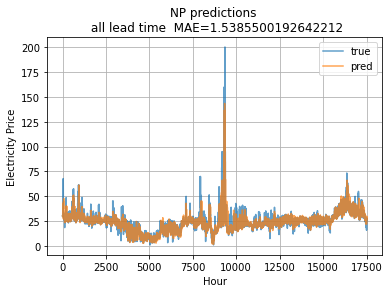

,unique_id,metric,nbeatsx,id,dnn,perc_diff,improvement
0,NP,MAE,1.53855,1,1.67,-7.871256,True
1,NP,MAPE,7.05399,1,5.38,31.115056,False
2,NP,SMAPE,6.93855,1,4.85,43.062887,False
3,NP,RMSE,3.36322,1,3.33,0.997597,False


In [8]:
y_true, y_hat, _ = model.predict(ts_loader=val_ts_loader, eval_mode=True)

print("y_true.shape \t\t(#n_windows, #lt) \t", y_true.shape)
print("y_hat.shape  \t\t(#n_windows, #lt) \t", y_hat.shape)
print("\n")

# Reshape for univariate and panel model compatibility
n_series = val_ts_loader.ts_dataset.n_series
n_fcds = len(y_true) // n_series
output_size = y_hat.shape[1]
y_true = y_true.reshape(n_series, n_fcds, output_size)
y_hat = y_hat.reshape(n_series, n_fcds, output_size)

print("y_true.shape \t\t(#n_series, #n_fcds, #lt) \t", y_true.shape)
print("y_hat.shape  \t\t(#n_series, #n_fcds, #lt) \t", y_hat.shape)
print("\n")

performance_df = {'unique_id': [], 'metric': [], 'nbeatsx': []}
for i, meta_data in enumerate(val_ts_loader.ts_dataset.meta_data):
    #dataset = meta_data['unique_id']
    y_hat_plot = y_hat[i,:,:].reshape(-1)
    y_true_plot = y_true[i,:,:].reshape(-1)

    # Create performance table
    market = val_ts_loader.ts_dataset.meta_data[i]['unique_id']
    performance_df['unique_id'] += [market]*4
    performance_df['metric'] += ['MAE', 'MAPE', 'SMAPE', 'RMSE']
    performance = forecast_evaluation_table(y_true_plot, y_hat_plot)
    performance_df['nbeatsx'] += performance.measure.to_list()
    
    performance = np.round(mae(y=y_true_plot, y_hat=y_hat_plot), 5)
    plt.plot(range(len(y_true_plot)), y_true_plot, label='true', alpha=0.7)
    plt.plot(range(len(y_hat_plot)), y_hat_plot, label='pred', alpha=0.7)
    plt.title(f"{market} predictions \n all lead time  MAE={performance}")
    plt.xlabel('Hour')
    plt.ylabel('Electricity Price')
    plt.legend()
    plt.grid()
    plt.show()

performance_df = pd.DataFrame(performance_df)
benchmark_df = pd.DataFrame({'id': [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4],
                             'unique_id': ['NP', 'NP', 'NP', 'NP', 'PJM', 'PJM', 'PJM', 'PJM',
                                           'BE', 'BE', 'BE', 'BE', 'FR', 'FR', 'FR', 'FR'],
                             'metric': ['MAE', 'MAPE', 'SMAPE', 'RMSE', 'MAE', 'MAPE', 'SMAPE', 'RMSE',
                                        'MAE', 'MAPE', 'SMAPE', 'RMSE', 'MAE', 'MAPE', 'SMAPE', 'RMSE'],    
                             'dnn' : [1.67, 5.38, 4.85, 3.33, 2.78, 28.66, 11.22, 4.64, 5.82,
                                      26.11, 13.33, 16.13, 3.91, 14.77, 10.98, 11.74]})

benchmark_df.sort_values(['id'], inplace=True)
benchmark_df.reset_index(drop=True, inplace=True)
benchmark_df = performance_df.merge(benchmark_df, on=['unique_id', 'metric'], how='left')
benchmark_df['perc_diff'] = 100 * (benchmark_df['nbeatsx']-benchmark_df['dnn'])/benchmark_df['dnn']
benchmark_df['improvement'] = benchmark_df['perc_diff'] < 0
benchmark_df